In [1]:
#!cp "drive/My Drive/Colab Notebooks/HW3/main.py"

#!cp --help

#!cd "drive/My Drive/Colab Notebooks/HW3/"

from google.colab import drive
drive.mount('/content/gdrive/')

#import sys
#sys.path.append('/content/gdrive/My Drive/Colab Notebooks/HW3/')

#import main
#import drive.My Drive.Colab Notebooks/HW3/main.py

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


**Prepare Dataset**

In [2]:
import os

# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
	!git clone https://github.com/MachineLearning2020/Homework3-PACS.git

# Clone github repository with data
if not os.path.isdir('./models'):
  !git clone https://github.com/gabrieletiboni/DANN-on-PACS-dataset.git
  !cp -r "/content/DANN-on-PACS-dataset/CODE/functions" "/content/"
  !cp -r "/content/DANN-on-PACS-dataset/CODE/models" "/content/"

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 13.97 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.
Cloning into 'DANN-on-PACS-dataset'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 73 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (73/73), done.


**Import libraries**

In [0]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

import logging
import os

import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
#from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

from models.AlexNetDANN import alexnetDANN
from functions.functions import *

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'
NUM_CLASSES = 7
# DIR_RUNS = '02 VERE PROVE/'
DIR_RUNS = '/content/gdrive/My Drive/Colab Notebooks/HW3/RUNS/'

if not os.path.isdir(DIR_RUNS):
  os.makedirs(DIR_RUNS)

# -----------------
ID_RUN = 'ZZZ'
RUN_NUMBER = '0'

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
										 # the batch size, learning rate should change by the same factor to have comparable results

LR = 5e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 5      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 3        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
ALPHA = 0.1					   # Multiplicative factor for the backpropogating gradient from the domain_classifier

DOMAIN_ADAPTATION = False
EVAL_ACCURACY_ON_TRAINING = False
EVAL_LOSS_AND_ACCURACY_ON_VALIDATION = True

**Define Data Preprocessing**

In [5]:
MEANS, STDS = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

# Define transforms for training phase
train_transform = transforms.Compose([#transforms.Resize(256),      # Resizes short size of the PIL image to 256
									transforms.CenterCrop(224),  # Crops a central square patch of the image
																	 # 224 because torchvision's AlexNet needs a 224x224 input!
																	 # Remember this when applying different transformations, otherwise you get an error
									transforms.ToTensor(), # Turn PIL Image to torch.Tensor
									transforms.Normalize(MEANS, STDS) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([#transforms.Resize(256),
									transforms.CenterCrop(224),
									transforms.ToTensor(),
									transforms.Normalize(MEANS, STDS)
])

DATA_DIR = 'Homework3-PACS/PACS'

photo_dataset = torchvision.datasets.ImageFolder(DATA_DIR+'/photo', transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(DATA_DIR+'/art_painting', transform=train_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(DATA_DIR+'/cartoon', transform=eval_transform)
sketch_dataset = torchvision.datasets.ImageFolder(DATA_DIR+'/sketch', transform=eval_transform)

PACSdataset = [photo_dataset, art_dataset, cartoon_dataset, sketch_dataset]

# Check dataset sizes
print('Photo Dataset: {}'.format(len(photo_dataset)))
print('Art Dataset: {}'.format(len(art_dataset)))
print('Cartoon Dataset: {}'.format(len(cartoon_dataset)))
print('Sketch Dataset: {}'.format(len(sketch_dataset)))

print('Classes:', photo_dataset.classes)

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929
Classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


**Data exploration**

In [0]:
# --- Print some images
# nPhotos = 4
# for dataset in PACSdataset:
# 	for i in range(nPhotos):
# 		index = np.random.randint(0, len(dataset))
# 		imgshow(dataset[index][0])

# --- Explore class distributions across domains
# labels_photo = photo_dataset.targets
# labels_art = art_dataset.targets
# labels_cartoon = cartoon_dataset.targets
# labels_sketch = sketch_dataset.targets
# plotBar(labels_photo, labels_art, labels_cartoon, labels_sketch, photo_dataset.classes)

**Prepare Dataloaders**

In [0]:
# --- Training dataloaders
photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
art_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

# --- Test datasets
photo_test_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
art_test_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
cartoon_test_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
sketch_test_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# DEBUG
# Split train into train and val
#train_indexes, test_indexes, _, _ = train_test_split([i for i in range(len(photo_dataset))], labels_photo, test_size=0.3, stratify=labels_photo)

#train_dataset = Subset(photo_dataset, train_indexes)
#test_dataset = Subset(photo_dataset, test_indexes)

#train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
#test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


**Prepare Network**

In [0]:
# net = alexnetDANN(pretrained=True)

# --- Check that pretrined weights have been correctly copied into the domain_classifier branch as well
#for domain_param, classifier_param in zip(list(net.classifier.parameters()), list(net.domain_classifier.parameters())):
  #print(torch.allclose(domain_param, classifier_param))

**Prepare Training**

In [0]:
# # Define loss function
# criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
# criterion_val = nn.CrossEntropyLoss(reduction='sum') # for evaluation I don't want to avg over every minibatch

# # Choose parameters to optimize
# parameters_to_optimize = net.parameters()

# # Define optimizer
# # An optimizer updates the weights based on loss
# # We use SGD with momentum
# optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# # Define scheduler
# # A scheduler dynamically changes learning rate
# # The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [0]:
global_accuracies = []
global_accuracies_full = []
j = 0

source_dataloader = photo_dataloader
source_test_dataloader = photo_test_dataloader

target_dataloaders = [cartoon_dataloader, sketch_dataloader]
target_test_dataloaders = [cartoon_test_dataloader, sketch_test_dataloader]
target_datasets = [cartoon_dataset, sketch_dataset]

for target_dataloader, target_test_dataloader, target_dataset in zip(target_dataloaders, target_test_dataloaders, target_datasets):

  if j==0:
    target_string = 'cartoon'
  else:
    target_string = 'sketch'

  print('********')
  print('STARTING TARGET:', target_string)
  print('********')

  net = alexnetDANN(pretrained=True)

  # Define loss function
  criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
  criterion_val = nn.CrossEntropyLoss(reduction='sum') # for evaluation I don't want to avg over every minibatch

  # Choose parameters to optimize
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

  # Define scheduler
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  net = net.to(DEVICE)

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  losses_train = []
  losses_train_classifier = []
  losses_train_domain = []
  losses_val = []
  accuracies_val = []
  accuracies_train = []
  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    if DOMAIN_ADAPTATION:
      len_dataloader = min(len(source_dataloader), len(target_dataloader))
      data_source_iter = iter(source_dataloader)
      data_target_iter = iter(target_dataloader)
    else:
      len_dataloader = len(source_dataloader)
      data_source_iter = iter(source_dataloader)

    i = 0
    while i < len_dataloader:
    #for images, labels in source_dataloader:
      # Bring data over the device of choice
      data_source = data_source_iter.next()
      s_images, s_labels = data_source

      #print('Batch size inferred 1:', len(s_labels))

      s_images = s_images.to(DEVICE)
      s_labels = s_labels.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      if DOMAIN_ADAPTATION:
        # FEED-FORWARD SOURCE TO CLASSIFIER
        source_classifier_outputs = net(s_images, dest='classifier')
        source_classifier_err = criterion(source_classifier_outputs, s_labels)

        # FEED-FORWARD SOURCE TO DOMAIN_CLASSIFIER
        source_domain_outputs = net(s_images, alpha=ALPHA, dest='domain_classifier')
        source_domain_labels = torch.zeros(BATCH_SIZE).long().to(DEVICE)
        source_domain_err = criterion(source_domain_outputs, source_domain_labels)

        # FEED-FORWARD TARGET TO DOMAIN_CLASSIFIER
        data_target = data_target_iter.next()
        t_images, t_labels = data_target

        #print('Batch size inferred 2:', len(t_labels))

        t_images = t_images.to(DEVICE)
        t_labels = t_labels.to(DEVICE)

        target_domain_outputs = net(t_images, alpha=ALPHA, dest='domain_classifier')
        target_domain_labels = torch.ones(BATCH_SIZE).long().to(DEVICE)
        target_domain_err = criterion(target_domain_outputs, target_domain_labels)

        loss = source_classifier_err + source_domain_err + target_domain_err

      else:
        # Forward pass to the network
        outputs = net(s_images, dest='classifier')
        # Compute loss based on output and ground truth
        loss = criterion(outputs, s_labels)

      if current_step == 0 and DOMAIN_ADAPTATION == False:
        print('--- Initial loss on train: {}'.format(loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1
      i +=1

    # End of one epoch    
    if DOMAIN_ADAPTATION:
      print('--- Epoch {}'.format(epoch+1))
      losses_train_classifier.append(source_classifier_err.item())
      losses_train_domain.append((source_domain_err.item()+target_domain_err.item()))
    else:
      print('--- Epoch {}, Loss on train: {}'.format(epoch+1, loss.item()))
      losses_train.append(loss.item())
    
    if EVAL_LOSS_AND_ACCURACY_ON_VALIDATION:
      
      net.train(False)

      running_corrects_val = 0
      cum_loss_val = 0

      #for images_val, labels_val in tqdm(val_dataloader):
      for images_val, labels_val in target_test_dataloader:
        images_val = images_val.to(DEVICE)
        labels_val = labels_val.to(DEVICE)

        # Forward Pass
        outputs_val = net(images_val, dest='classifier')

        cum_loss_val += criterion_val(outputs_val, labels_val).item()

        # Get predictions
        _, preds = torch.max(outputs_val.data, 1)

        # Update Corrects
        running_corrects_val += torch.sum(preds == labels_val.data).data.item()

      # Calculate Accuracy
      accuracy_val = running_corrects_val / float(len(target_dataset))
      loss_val = cum_loss_val / float(len(target_dataset))

      losses_val.append(loss_val)
      accuracies_val.append(accuracy_val)
      
      print('Loss on val:', loss_val)
      print('Accuracy on val:', accuracy_val)

    if EVAL_ACCURACY_ON_TRAINING:
      net.train(False)

      running_corrects_train = 0

      for images_train, labels_train in source_test_dataloader:
        images_train = images_train.to(DEVICE)
        labels_train = labels_train.to(DEVICE)

        # Forward Pass
        outputs_train = net(images_train, dest='classifier')

        # Get predictions
        _, preds = torch.max(outputs_train.data, 1)

        # Update Corrects
        running_corrects_train += torch.sum(preds == labels_train.data).data.item()

      # Calculate Accuracy
      accuracy_train = running_corrects_train / float(len(photo_dataset))

      accuracies_train.append(accuracy_train)

      print('Accuracy on train:', accuracy_train)

    # Step the scheduler
    scheduler.step()

  # END OF TRAINING FOR ONE TARGET
  global_accuracies.append(accuracies_val[-1])
  global_accuracies_full.append(accuracies_val)

  # with open(DIR_RUNS+ID_RUN+' - '+str(target_string)+' - values.txt', 'a+') as f:
  #   print('TL:', file=f)
  #   print(losses_train, file=f)
  #   print('Classifier loss on source:', file=f)
  #   print(losses_train_classifier, file=f)
  #   print('Domain classifier loss:', file=f)
  #   print(losses_train_domain, file=f)
  #   print(losses_val, file=f)
  #   print(accuracies_train, file=f)
  #   print(accuracies_val, file=f)
  #   print('', file=f)
  
  j +=1

# END OF TRAINING
print('GLOBAL ACCURACIES:', global_accuracies)
print('MEAN:', np.mean(global_accuracies))

**Debug**

In [22]:
# print('TL:')
# print(losses_train)
# print('Classifier loss on source:')
# print(losses_train_classifier)
# print('Domain classifier loss:')
# print(losses_train_domain)
# print(losses_val)
# print(accuracies_train)
# print(accuracies_val)
# print()

# if not os.path.isdir(DIR_RUNS):
#   os.makedirs(DIR_RUNS)

# with open(DIR_RUNS+ID_RUN+' - values.txt', 'a+') as f:
#   print('TL:', file=f)
#   print(losses_train, file=f)
#   print('Classifier loss on source:', file=f)
#   print(losses_train_classifier, file=f)
#   print('Domain classifier loss:', file=f)
#   print(losses_train_domain, file=f)
#   print(losses_val, file=f)
#   print(accuracies_train, file=f)
#   print(accuracies_val, file=f)
#   print('', file=f)

print(global_accuracies_full)

with open(DIR_RUNS+ID_RUN+' - values.txt', 'a+') as f:
  print('CARTOON:', file=f)
  print(global_accuracies_full[0], file=f)

  print('---', file=f)
  print('SKETCH', file=f)
  print(global_accuracies_full[1], file=f)
  print('*******************', file=f)
  print('', file=f)

[[0.18387372013651876, 0.26109215017064846, 0.33575085324232085, 0.3476962457337884, 0.3609215017064846], [0.26749809111733264, 0.2921863069483329, 0.2618987019597862, 0.25400865360142527, 0.2504454059557139]]


**Plot results**

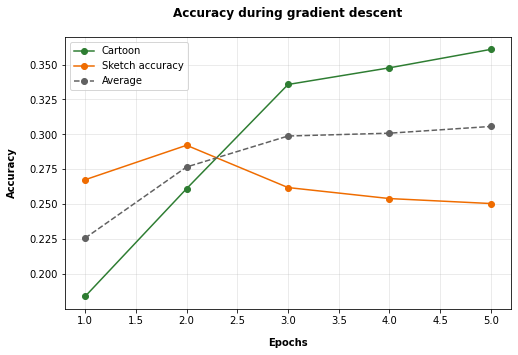

In [17]:
# --- Plot accuracies TARGET CARTOON and SKETCH + MEAN

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, NUM_EPOCHS+1)]
average = np.mean(np.array(global_accuracies_full), axis=-2)
# ax.plot(epochs, accuracies_train, color='#7B1FA2', linestyle='-', marker='o', label='Training accuracy')
ax.plot(epochs, global_accuracies_full[0], color='#2E7D32', linestyle='-', marker='o', label='Cartoon')
ax.plot(epochs, global_accuracies_full[1], color='#EF6C00', linestyle='-', marker='o', label='Sketch accuracy')
ax.plot(epochs, average, color='#616161', linestyle='--', marker='o', label='Average')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

fig.savefig(DIR_RUNS+ID_RUN+' - '+str(RUN_NUMBER)+' - accuracies.png')

# --- Plot accuracies TARGET SKETCH

# fig.savefig(DIR_RUNS+ID_RUN+' '+str(RUN_NUMBER)+' - accuracy cartoon.png')

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

# epochs = [i for i in range(1, NUM_EPOCHS+1)]
# ax.plot(epochs, global_accuracies_full[1], color='#EF6C00', linestyle='-', marker='o', label='Sketch accuracy')

# ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
# ax.set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

# ax.set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

# ax.legend()
# plt.grid(alpha=0.3)
# plt.show()

# fig.savefig(DIR_RUNS+ID_RUN+' '+str(RUN_NUMBER)+' - accuracy sketch.png')

**Test**

In [13]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(art_test_dataloader):
	images = images.to(DEVICE)
	labels = labels.to(DEVICE)

	# Forward Pass
	outputs = net(images, dest='classifier')

	# Get predictions
	_, preds = torch.max(outputs.data, 1)

	# Update Corrects
	running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(art_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Test Accuracy: 0.44384765625


In [0]:
# !zip -r "/content/RUNS_4.zip" "/content/02 VERE PROVE"

# from google.colab import files
# files.download("/content/RUNS_4.zip")